## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [12]:
!pwd

/content


In [13]:
%cd drive/My Drive/ML_100/day86 

/content/drive/My Drive/ML_100/day86


In [1]:
import os
import keras

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [14]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

save = [True , False]

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for save in (save):
    keras.backend.clear_session() # 把舊的 Graph 清掉

    model = build_mlp(input_shape=x_train.shape[1:])
    
    optimizer = keras.optimizers.SGD(lr = LEARNING_RATE, nesterov=True, momentum = MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["acc"], optimizer=optimizer)

    model_ckpt = ModelCheckpoint(filepath = './weights.{epoch:02d}-{val_loss:.2f}.hdf5' ,
                             monitor = 'val_loss' ,
                             save_best_only = save ,
                             save_weights_only = True , 
                             verbose = 1
                            )

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True ,
              callbacks = [model_ckpt]
              )
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-save_best_only:%s" % str(save)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 2s 38us/step - loss: 2.2407 - acc: 0.2631 - val_loss: 2.1851 - val_acc: 0.1942

Epoch 00001: val_loss improved from inf to 2.18508, saving model to ./weights.01-2.19.hdf5
Epoch 2/20
50000/50000 [==============================] - 2s 30us/step - loss: 1.7558 - acc: 0.3894 - val_loss: 1.9911 - val_acc: 0.2637

Epoch 00002: val_loss improved from 2.18508 to 1.99106, saving model to ./weights.02-1.99.hdf5
Epoch 3/20
50000/50000 [==============================] - 2s 30us/step - loss: 1.6304 - acc: 0.4340 - val_loss: 1.8392 - val_acc: 0.3357

Epoch 00003: val_loss improved from 1.99106 to 1.83922, saving model to ./weights.03-1.84.hdf5
Epoch 4/20
50000/50000 [==============================] - 2s 30us/step - loss: 1.5581 - acc: 0.4578 - val_loss: 1.7298 - val_acc: 0.3792

Epoch 00004: val_loss improved from 1.83922 to 1.72983, saving model to ./weights.04-1.73.hdf5
Epoch 5/20
50000/50000

10000/10000 [==============================] - 1s 125us/step


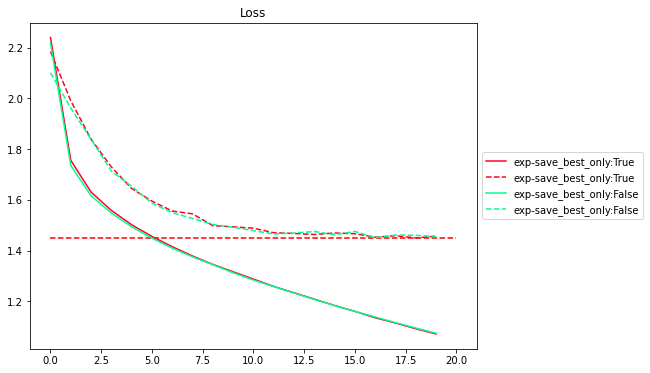

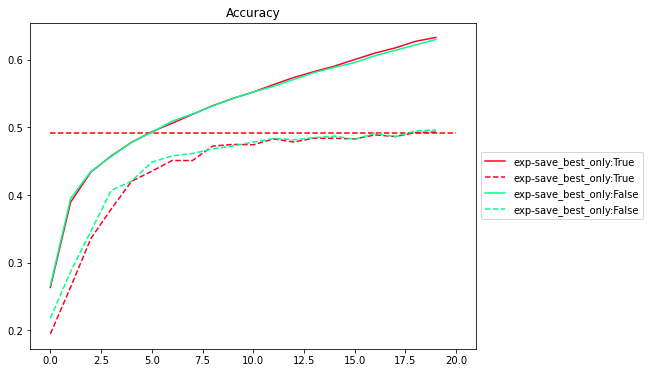

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline 
    
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

# 匯入
model1 = build_mlp(input_shape=x_train.shape[1:])
model1.load_weights('./weights.19-1.45.hdf5')
model1.compile(loss="categorical_crossentropy", optimizer=optimizer ,metrics = ['acc'])
loss_loadback, acc_loadback = model1.evaluate(x_test , y_test)

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

